In [446]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [447]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matspy import spy
import json
from pipeliner.recommendations.transformer import (
    UserItemMatrixTransformer,
    SimilarityTransformer,
)
from pipeliner.recommendations.recommender import SimilarityRecommender

In [448]:
# Create a toy dataset

NUM_USERS = 12
NUM_ITEMS = 12

# Create arrays for each column
users = np.repeat(np.arange(NUM_USERS), 4)
stacked = np.hstack([np.arange(NUM_ITEMS), np.arange(3)])
strides = np.lib.stride_tricks.sliding_window_view(stacked, 4)
items = strides.reshape(-1)
ratings = np.tile([1, 0.5, 0.5, 0.25], 12)

# Stack arrays to get (user, item, rating) combinations
user_item_ratings_generated = np.column_stack((users, items, ratings)).astype(np.float32)

user_item_ratings_df = pd.DataFrame(
    user_item_ratings_generated, columns=["user_id", "item_id", "rating"]
)
user_item_ratings_df.user_id = user_item_ratings_df.user_id.astype(int).map(
    lambda i: f"U{i + 1:05d}"
)
user_item_ratings_df.item_id = user_item_ratings_df.item_id.astype(int).map(
    lambda i: f"I{i + 1:05d}"
)
user_item_ratings_df.to_csv(
    "../../tests/test_data/user_item_ratings_toy.csv", index=False
)
display(user_item_ratings_df.head(12))

,user_id,item_id,rating
0,U00001,I00001,1.00
1,U00001,I00002,0.50
2,U00001,I00003,0.50
3,U00001,I00004,0.25
4,U00002,I00002,1.00
5,U00002,I00003,0.50
6,U00002,I00004,0.50
7,U00002,I00005,0.25
8,U00003,I00003,1.00
9,U00003,I00004,0.50


In [449]:
users = user_item_ratings_df.user_id.unique()
items = user_item_ratings_df.item_id.unique()
user_item_matrix_transformer = UserItemMatrixTransformer()
user_item_matrix = user_item_matrix_transformer.transform(
    user_item_ratings_generated
)
user_item_matrix_df = pd.DataFrame(
    user_item_matrix, index=users, columns=items
).astype(np.float32)
user_item_matrix_df.index.name = "user_id"
display(user_item_matrix_df)
user_item_matrix_df.to_csv(
    "../../tests/test_data/user_item_matrix_toy.csv", index=True
)

user_similarity_matrix_transformer = SimilarityTransformer()
user_similarity_matrix = user_similarity_matrix_transformer.transform(user_item_matrix)
user_similarity_matrix_df = pd.DataFrame(
    user_similarity_matrix, index=users, columns=users
).astype(np.float32)
user_similarity_matrix_df.index.name = "user_id"
display(user_similarity_matrix_df)
user_similarity_matrix_df.to_csv(
    "../../tests/test_data/user_similarity_matrix_toy.csv", index=True
)

item_similarity_matrix_transformer = SimilarityTransformer()
item_similarity_matrix = item_similarity_matrix_transformer.transform(
    user_item_matrix.T
)
item_similarity_matrix_df = pd.DataFrame(
    item_similarity_matrix, index=items, columns=items
).astype(np.float32)
item_similarity_matrix_df.index.name = "item_id"
display(item_similarity_matrix_df)
item_similarity_matrix_df.to_csv(
    "../../tests/test_data/item_similarity_matrix_toy.csv", index=True
)

,I00001,I00002,I00003,I00004,I00005,I00006,I00007,I00008,I00009,I00010,I00011,I00012
user_id,,,,,,,,,,,,
U00001,1.00,0.50,0.50,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
U00002,0.00,1.00,0.50,0.50,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
U00003,0.00,0.00,1.00,0.50,0.50,0.25,0.00,0.00,0.00,0.00,0.00,0.00
U00004,0.00,0.00,0.00,1.00,0.50,0.50,0.25,0.00,0.00,0.00,0.00,0.00
U00005,0.00,0.00,0.00,0.00,1.00,0.50,0.50,0.25,0.00,0.00,0.00,0.00
U00006,0.00,0.00,0.00,0.00,0.00,1.00,0.50,0.50,0.25,0.00,0.00,0.00
U00007,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50,0.50,0.25,0.00,0.00
U00008,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50,0.50,0.25,0.00
U00009,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50,0.50,0.25


,U00001,U00002,U00003,U00004,U00005,U00006,U00007,U00008,U00009,U00010,U00011,U00012
user_id,,,,,,,,,,,,
U00001,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00,0.00,0.16,0.40,0.56
U00002,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00,0.00,0.16,0.40
U00003,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00,0.00,0.16
U00004,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00,0.00
U00005,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00
U00006,0.00,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00
U00007,0.00,0.00,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00
U00008,0.00,0.00,0.00,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00
U00009,0.00,0.00,0.00,0.00,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16


,I00001,I00002,I00003,I00004,I00005,I00006,I00007,I00008,I00009,I00010,I00011,I00012
item_id,,,,,,,,,,,,
I00001,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00,0.00,0.16,0.40,0.56
I00002,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00,0.00,0.16,0.40
I00003,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00,0.00,0.16
I00004,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00,0.00
I00005,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00,0.00
I00006,0.00,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00,0.00
I00007,0.00,0.00,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00,0.00
I00008,0.00,0.00,0.00,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16,0.00
I00009,0.00,0.00,0.00,0.00,0.00,0.16,0.40,0.56,1.00,0.56,0.40,0.16


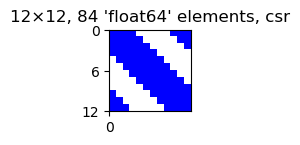

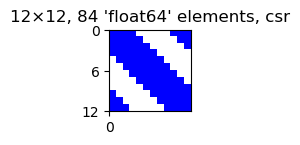

In [450]:
spy(sp.sparse.csr_matrix(item_similarity_matrix))
spy(sp.sparse.csr_matrix(user_similarity_matrix))

In [451]:
item_ids = user_item_matrix_df.columns

item_encoder = LabelEncoder()
item_ids_encoded = item_encoder.fit_transform(item_ids)

similarity_rec = SimilarityRecommender(10)
similarity_rec.fit(item_similarity_matrix)
item_recs = similarity_rec.recommend(item_ids_encoded)

results = [item_encoder.inverse_transform(item).tolist() for item in item_recs]
similarity_recommendations_toy = {item_id: result for item_id, result in zip(item_ids, results)}

with open("../../tests/test_data/similarity_recommendations_toy.json", "w") as f:
    f.write(json.dumps(similarity_recommendations_toy, indent=4))

item_probs = similarity_rec.predict_proba(item_ids_encoded).toarray().astype(np.float32).round(6)
np.save("../../tests/test_data/similarity_recommendations_toy_probs.npy", item_probs)